# Kernel Functions Profiling

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

10:59:21  DEBUG   : loading JSON...
10:59:21  DEBUG   : Loaded JSON configuration:
10:59:21  DEBUG   :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 112}, u'cpu': {u'cap_max': 1024, u'nrg_max': 670}}, u'little': {u'cluster': {u'nrg_max': 112}, u'cpu': {u'cap_max': 1024, u'nrg_max': 670}}}, u'board': {u'big_core': u'A53_1', u'cores': [u'A53_0', u'A53_0', u'A53_0', u'A53_0', u'A53_1', u'A53_1', u'A53_1', u'A53_1'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
10:59:21  DEBUG   : loading JSON...
10:59:21  DEBUG   : Loaded JSON configuration:
10:59:21  DEBUG   :    {u'board': {u'big_core': u'A57', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A57', u'A57'], u'modules': [u'bl', u'cpufreq']}}
10:59:21  DEBUG   : loading JSON...
10:59:21  DEBUG   : Loaded JSON configuration:
10:59:21  DEBUG   :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 96}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1715}}, u'little': {u'cluster': {u'nrg_max': 52}, u'cpu': {u'cap_max': 763, u'nrg_max': 925}}}, u

In [3]:
import re

CPU_RE = re.compile(r'  Function \(CPU([0-9]+)\)')
STATS_RE = re.compile(r'([^ ]*) +([0-9]+) +([0-9.]+) us +([0-9.]+) us +([0-9.]+) us')

def get_stats(outdir):
    if os.path.isdir(outdir):
        outfile = os.path.join(outdir, 'trace.stats')
   
    with open(os.path.join(outdir, 'function.stats'), 'r') as fh_stat:
        output = fh_stat.read()

    function_stats = {}
    for line in output.splitlines():
        # Match a new CPU dataset
        match = CPU_RE.search(line)
        if match:
            cpu_id = int(match.group(1))
            function_stats[cpu_id] = {}
            logging.info("Processing stats for CPU%d...", cpu_id)
            continue
        # Match a new function dataset
        match = STATS_RE.search(line)
        if match:
            fname = match.group(1)
            function_stats[cpu_id][fname] = {
                    'hits' : int(match.group(2)),
                    'time' : float(match.group(3)),
                    'avg'  : float(match.group(4)),
                    's_2'  : float(match.group(5)),
                }
            logging.info(" %s: %s",
                         fname, function_stats[cpu_id][fname])

    logging.info("FTrace stats output [%s]...", outfile)
    with open(outfile, 'w') as fh:
       json.dump(function_stats, fh, indent=4)
    logging.info("FTrace function stats save in [%s]", outfile)

    return function_stats


# Target Configuration

In [4]:
# Setup target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")
my_conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
#             'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },  

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_FunctionsProfiling",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "functions" : [
#             "pick_next_task_fair",
#             "select_task_rq_fair",
#             "enqueue_task_fair",
#             "update_curr_fair",
#             "dequeue_task_fair",
            
#             # for tests
#             "scheduler_timeout",
#             "tick_sched_timer",
#             "tick_sched_do_timer",
#             "schedtune_cpu_boost",
#             "schedtune_task_boost",
#             "schedtune_prefer_idle",
#             "schedtune_enqueue_task",
#             "schedtune_dequeue_task",
            "SyS_read",
            "SyS_write",
            "SyS_execve",
            "SyS_open",
            "SyS_openat",
            "SyS_fstat64",
            "SyS_fstatat64",
            "SyS_getdents",
            "SyS_getdents64",
            "SyS_close",
            "SyS_clock_gettime",
            "SyS_gettimeofday",
            "compat_SyS_clock_gettime",
            "sys_mmap",
            "SyS_mmap_pgoff",
            "SyS_mprotect",
            "SyS_clone",
            "SyS_futex",

        ],
        
         "events" : [
             "sched_switch",
             "cpu_frequency"
             
         ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    

}

In [10]:
# Initialize a test environment using:
te = TestEnv(my_conf)
target = te.target

04:23:30  INFO    : Using base path: /home/steven/lisa/lisa-github
04:23:30  INFO    : Loading custom (inline) target configuration
04:23:30  DEBUG   : Target configuration {'platform': 'android', 'emeter': {'instrument': 'acme', 'channel_map': {'Device1': 1, 'Device0': 0}, 'conf': {'iio-capture': '/usr/bin/iio-capture'}}, 'ftrace': {'buffsize': 102400, 'functions': ['SyS_read', 'SyS_write', 'SyS_execve', 'SyS_open', 'SyS_openat', 'SyS_fstat64', 'SyS_fstatat64', 'SyS_getdents', 'SyS_getdents64', 'SyS_close', 'SyS_clock_gettime', 'SyS_gettimeofday', 'compat_SyS_clock_gettime', 'sys_mmap', 'SyS_mmap_pgoff', 'SyS_mprotect', 'SyS_clone', 'SyS_futex'], 'events': ['sched_switch', 'cpu_frequency', 'cpu_frequency_devlib', 'cpu_frequency_devlib']}, 'board': 'hikey960', 'rtapp-calib': {'1': 302, '0': 302, '3': 304, '2': 304, '5': 137, '4': 136, '7': 136, '6': 136}, 'exclude_modules': ['hwmon'], 'device': '0123456789ABCDEF', 'ANDROID_HOME': '/home/steven/lisa/lisa-github/ipynb/kpti_test/../../../

04:23:32  DEBUG   : adb -s 0123456789ABCDEF shell mount
04:23:33  DEBUG   : adb -s 0123456789ABCDEF push '/home/steven/lisa/lisa-github/tools/arm64/rt-app' '/data/local/tmp/devlib-target/rt-app'
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell cp /data/local/tmp/devlib-target/rt-app /data/local/tmp/bin/rt-app
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell rm -rf "/data/local/tmp/devlib-target/rt-app"
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell chmod 0777 '/data/local/tmp/bin/rt-app'
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell mount
04:23:33  DEBUG   : adb -s 0123456789ABCDEF push '/home/steven/lisa/lisa-github/tools/arm64/perf' '/data/local/tmp/devlib-target/perf'
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell cp /data/local/tmp/devlib-target/perf /data/local/tmp/bin/perf
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell rm -rf "/data/local/tmp/devlib-target/perf"
04:23:33  DEBUG   : adb -s 0123456789ABCDEF shell chmod 0777 '/data/local/tmp/bin/perf'
04:23:33  DEBUG 

# Workload Execution and Functions Profiling Data Collection

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

10:31:06  INFO    : Setup new workload ramp
10:31:06  DEBUG   : Setup step [postrun] callback to [__postrun] function
10:31:06  DEBUG   : adb -s 0123456789ABCDEF shell mkdir -p /data/local/tmp/devlib-target
10:31:06  DEBUG   : Configuring a profile-based workload...
10:31:06  INFO    : Workload duration defined by longest task
10:31:06  INFO    : Default policy: SCHED_OTHER
10:31:06  INFO    : ------------------------
10:31:06  INFO    : task [ramp], sched: using default policy
10:31:06  INFO    :  | loops count: 1
10:31:06  INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
10:31:06  INFO    : |  period   100000 [us], duty_cycle  60 %
10:31:06  INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
10:31:06  INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
10:31:06  INFO    : |  period   100000 [us], duty_cycle  55 %
10:31:06  INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
10:31:06  INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
10:31:06  INFO 

10:31:20  DEBUG   :  SyS_mmap_pgoff: {'hits': 1495, 'avg': 13.554, 's_2': 3691.48, 'time': 20263.52}
10:31:20  DEBUG   :  SyS_mprotect: {'hits': 1168, 'avg': 7.665, 's_2': 498.756, 'time': 8953.109}
10:31:20  DEBUG   :  SyS_close: {'hits': 1910, 'avg': 1.285, 's_2': 1.26, 'time': 2455.207}
10:31:20  DEBUG   :  SyS_getdents64: {'hits': 20, 'avg': 59.635, 's_2': 12484.1, 'time': 1192.708}
10:31:20  DEBUG   :  SyS_clock_gettime: {'hits': 55, 'avg': 1.24, 's_2': 0.647, 'time': 68.221}
10:31:20  DEBUG   : Processing stats for CPU2...
10:31:20  DEBUG   :  SyS_futex: {'hits': 533, 'avg': 19955.63, 's_2': 38799259.0, 'time': 10636353.0}
10:31:20  DEBUG   :  SyS_read: {'hits': 393, 'avg': 7022.61, 's_2': 35099356.0, 'time': 2759885.0}
10:31:20  DEBUG   :  SyS_write: {'hits': 1156, 'avg': 421.238, 's_2': 8513181.0, 'time': 486952.0}
10:31:20  DEBUG   :  SyS_openat: {'hits': 353, 'avg': 91.741, 's_2': 797827.5, 'time': 32384.88}
10:31:20  DEBUG   :  sys_mmap: {'hits': 725, 'avg': 32.133, 's_2': 2

# Parse Trace and Profiling Data

In [5]:
# Base folder where tests folder are located
base_dir = '/home/steven/lisa/lisa-github/results/kpti/base/syscall-2'
kpti_dir = '/home/steven/lisa/lisa-github/results/kpti/kpti/syscall-2'
!tree {base_dir} {kpti_dir}

/home/steven/lisa/lisa-github/results/kpti/base/syscall-2
├── ftrace.sh
├── function.stats
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
└── trace.stats
/home/steven/lisa/lisa-github/results/kpti/kpti/syscall-2
├── ftrace.sh
├── function.stats
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
└── trace.stats

0 directories, 14 files


In [6]:
with open(os.path.join(base_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

10:59:38  INFO    : LITTLE cluster max capacity: 462


In [7]:
my_conf['ftrace']['events']

['sched_switch', 'cpu_frequency']

In [8]:
trace = Trace(platform, base_dir, events=my_conf['ftrace']['events'])
trace_kpti = Trace(platform, kpti_dir, events=my_conf['ftrace']['events'])

10:59:41  DEBUG   : Loading [sched] events from trace in [/home/steven/lisa/lisa-github/results/kpti/base/syscall-2]...
10:59:41  DEBUG   : Parsing events: ['sched_switch', 'cpu_frequency', 'cpu_frequency_devlib']
10:59:41  DEBUG   : Parsing FTrace format...
10:59:41  DEBUG   : Loading functions profiling data from [/home/steven/lisa/lisa-github/results/kpti/base/syscall-2/trace.stats]...
10:59:41  DEBUG   : Events found on trace:
10:59:41  DEBUG   :  - sched_switch
10:59:41  DEBUG   : Collected events spans a 5.880 [s] time interval
10:59:41  DEBUG   : Set plots time range to (0.000000, 5.880349)[s]
10:59:41  DEBUG   : Registering [<trace.Trace object at 0x7fd3e567cf10>] local data frames
10:59:41  DEBUG   :    functions_stats
10:59:41  DEBUG   :    trace_event
10:59:41  DEBUG   : Analysis: /home/steven/lisa/lisa-github/libs/utils/analysis
10:59:41  DEBUG   : Syspath: ['/home/steven/lisa/lisa-github/libs/utils/analysis', '', '/home/steven/lisa/lisa-github/libs/bart', '/home/steven/lis

10:59:42  DEBUG   :    frequency
10:59:42  DEBUG   : Filename: latency_analysis
10:59:42  DEBUG   : Registering [<latency_analysis.LatencyAnalysis object at 0x7fd3e4d7a5d0>] local data frames
10:59:42  DEBUG   :    activations_df
10:59:42  DEBUG   :    latency_df
10:59:42  DEBUG   :    latency_preemption_df
10:59:42  DEBUG   :    latency_wakeup_df
10:59:42  DEBUG   :    runtimes_df
10:59:42  DEBUG   :    task_residency
10:59:42  DEBUG   :    trace_event
10:59:42  DEBUG   :    latency
10:59:42  DEBUG   : Filename: tasks_analysis
10:59:42  DEBUG   : Registering [<tasks_analysis.TasksAnalysis object at 0x7fd3e4d7a750>] local data frames
10:59:42  DEBUG   :    rt_tasks
10:59:42  DEBUG   :    task_load_events
10:59:42  DEBUG   :    top_big_tasks
10:59:42  DEBUG   :    top_wakeup_tasks
10:59:42  DEBUG   :    trace_event
10:59:42  DEBUG   :    tasks
10:59:42  DEBUG   : Filename: thermal_analysis
10:59:42  DEBUG   : Registering [<thermal_analysis.ThermalAnalysis object at 0x7fd3e4d7a650>] loca

In [12]:
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(base_dir)

/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedLoadAvgTask object at 0x7f88f02bf650> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedContribScaleFactor object at 0x7f88f02bf310> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedCpuCapacity object at 0x7f88f02bfa10> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.thermal.Thermal object at 0x7f88f02bfd50> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedWakeupNew object a

# Report Functions Profiling Data

In [9]:
# Get the DataFrame for the specified list of kernel functions
df1 = trace.data_frame.functions_stats(['SyS_read', 'SyS_write'])
df2 = trace_kpti.data_frame.functions_stats(['SyS_read', 'SyS_write'])



In [10]:
df1.merge(df2, right_index=True, left_index=True, suffixes=("_base", "_kpti"))

hits_base   avg_base    time_base      s_2_base  hits_kpti  \
0 SyS_read         276    103.317    28515.610  9.741162e+05         93   
  SyS_write       1403    118.998   166955.200  6.268028e+06        341   
1 SyS_read         237    883.034   209279.100  7.251895e+07         49   
  SyS_write         27    458.294    12373.950  5.408826e+06          6   
2 SyS_read        8052     22.177   178574.900  1.593828e+05         58   
  SyS_write       4395    362.888  1594894.000  3.783465e+06        530   
3 SyS_read         293   1254.232   367490.100  9.696814e+07         62   
  SyS_write         56     12.518      701.044  1.024900e+02         45   
4 SyS_read          81     13.033     1055.727  1.756455e+03        130   
  SyS_write         43     15.007      645.307  2.377620e+02        206   
5 SyS_read         158    144.201    22783.850  1.114295e+06        183   
  SyS_write        342      5.031     1720.836  2.123700e+01         41   
6 SyS_read         168   2188.147   367608.800  3.606319e+08       8037   
  SyS_write        120      9.522     1142.699  2.047990e+02       4257   
7 SyS_read         159  32246.190  5127145.000  7.514108e+06        296   
  SyS_write         32      7.780      248.960  3.332000e+01        851   

             avg_kpti    time_kpti      s_2_kpti  
0 SyS_read    144.965    13481.770  1.352893e+06  
  SyS_write     8.205     2797.913  5.556600e+01  
1 SyS_read    334.109    16371.340  3.730108e+06  
  SyS_write    12.500       75.001  8.224700e+01  
2 SyS_read     19.423     1126.563  2.329687e+03  
  SyS_write     7.639     4048.962  3.735900e+01  
3 SyS_read    277.553    17208.330  4.466561e+06  
  SyS_write    32.685     1470.834  1.799224e+03  
4 SyS_read      3.633      472.388  9.961400e+01  
  SyS_write  6191.772  1275505.000  3.208794e+08  
5 SyS_read   1443.806   264216.600  7.406760e+07  
  SyS_write  6682.926   273999.900  6.123095e+08  
6 SyS_read     54.011   434090.600  1.521551e+07  
  SyS_write    69.580   296202.000  3.544739e+05  
7 SyS_read     58.505    17317.710  3.564978e+05  
  SyS_write     4.795     4081.241  1.272500e+01

In [11]:
# Get the DataFrame for the single specified kernel function
df1 = trace.data_frame.functions_stats('sys_mmap')
df2 = trace_kpti.data_frame.functions_stats('sys_mmap')

df1.merge(df2, right_index=True, left_index=True, suffixes=("_base", "_kpti"))

,,hits_base,avg_base,time_base,s_2_base,hits_kpti,avg_kpti,time_kpti,s_2_kpti
0,sys_mmap,1948,5.414,10548.410,11.818,183,6.047,1106.765,31.871
1,sys_mmap,1231,5.244,6456.246,23.597,283,5.515,1560.939,10.210
2,sys_mmap,427,5.818,2484.364,18.215,1126,5.823,6556.774,8.563
3,sys_mmap,2623,5.291,13879.180,22.365,185,5.594,1034.895,7.765
4,sys_mmap,89,4.494,400.000,7.012,726,3.795,2755.747,2.743
5,sys_mmap,1334,3.871,5164.608,4.859,383,3.723,1426.027,10.466
6,sys_mmap,1605,3.804,6105.747,2.774,458,4.673,2140.629,375.266
7,sys_mmap,663,3.726,2470.837,4.874,2866,3.714,10644.810,5.647


In [17]:
# Get the DataFrame for the single specified kernel function
df1 = trace.data_frame.functions_stats('SyS_clock_gettime')
df2 = trace_kpti.data_frame.functions_stats('SyS_clock_gettime')

df=df1.merge(df2, right_index=True, left_index=True, suffixes=("_base", "_kpti"))

# Plot Functions Profiling Data

# BASE_KERNEL

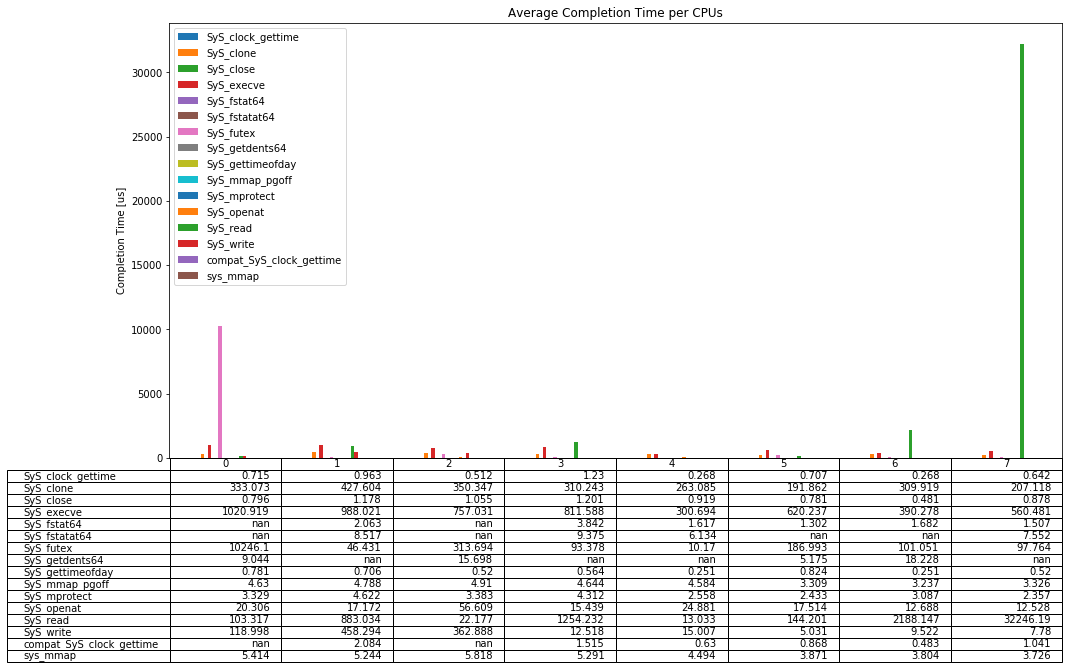

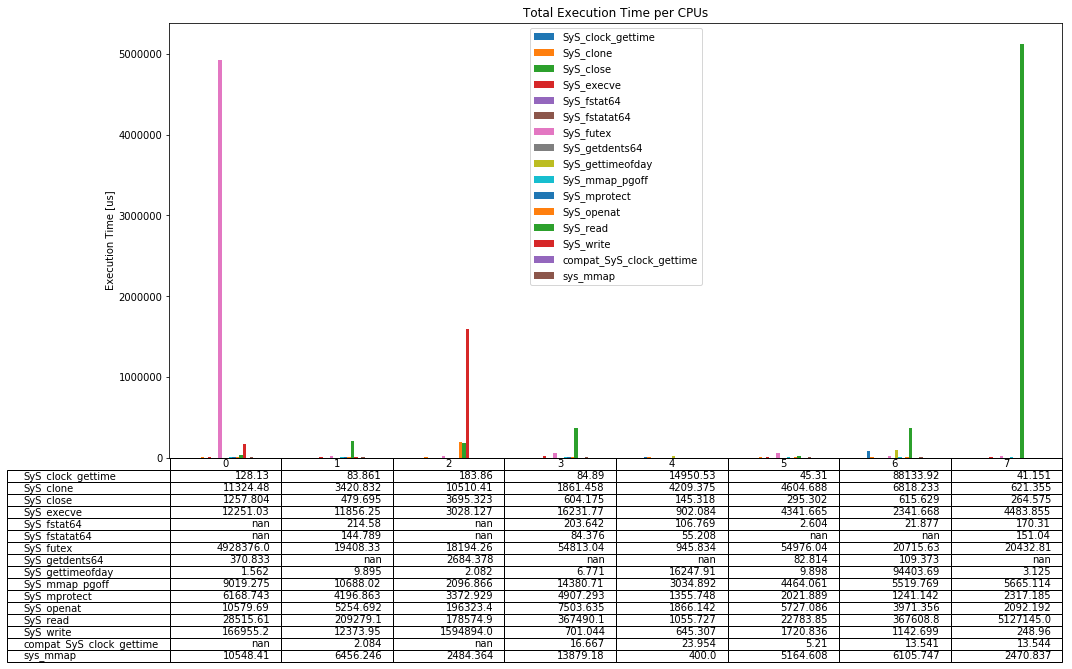

In [13]:
# Plot Average and Total execution time for the specified
# list of kernel functions
trace.analysis.functions.plotProfilingStats(
    functions = [
            "SyS_read",
            "SyS_write",
            "SyS_execve",
            "SyS_open",
            "SyS_openat",
            "SyS_fstat64",
            "SyS_fstatat64",
            "SyS_getdents",
            "SyS_getdents64",
            "SyS_close",
            "SyS_clock_gettime",
            "SyS_gettimeofday",
            "compat_SyS_clock_gettime",
            "sys_mmap",
            "SyS_mmap_pgoff",
            "SyS_mprotect",
            "SyS_clone",
            "SyS_futex",
    ],
    metrics = [
        'avg',
        'time',
    ]
)

# KPTI_ENABLE

.config - Linux/arm64 4.15.0-rc3 Kernel Configuration

  │ Symbol: UNMAP_KERNEL_AT_EL0 [=y]                                                                                                                                 │  
  │ Type  : boolean                                                                                                                                                  │  
  │ Prompt: Unmap kernel when running in userspace (aka "KAISER")                                                                                                    │  
  │   Location:                                                                                                                                                      │  
  │ (1) -> Kernel Features                                                                                                                                           │  
  │   Defined at arch/arm64/Kconfig:836      

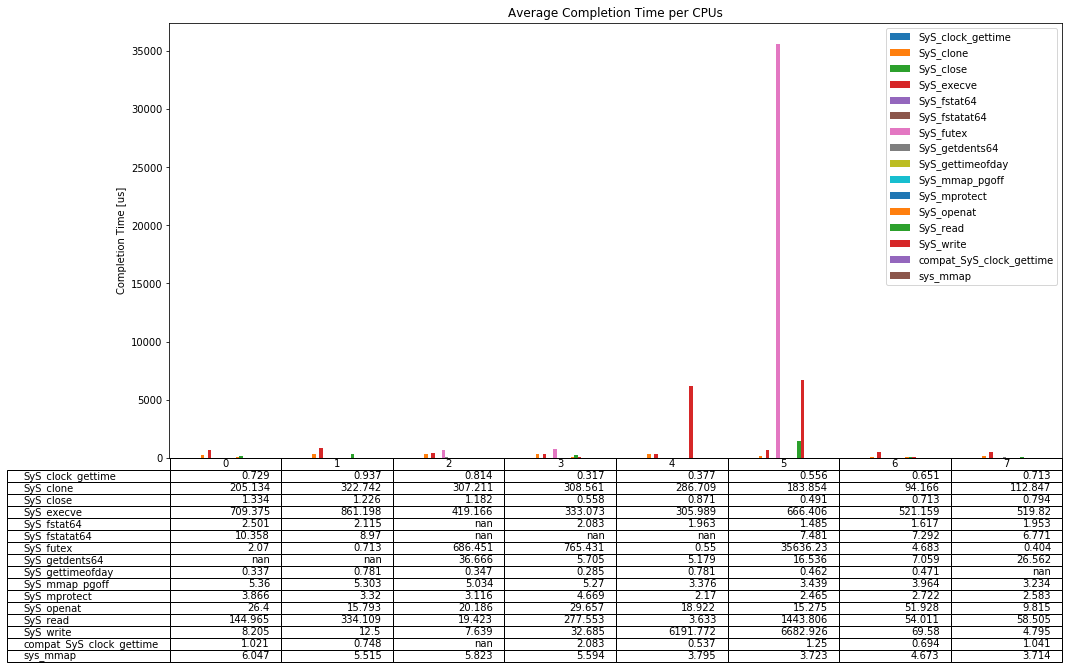

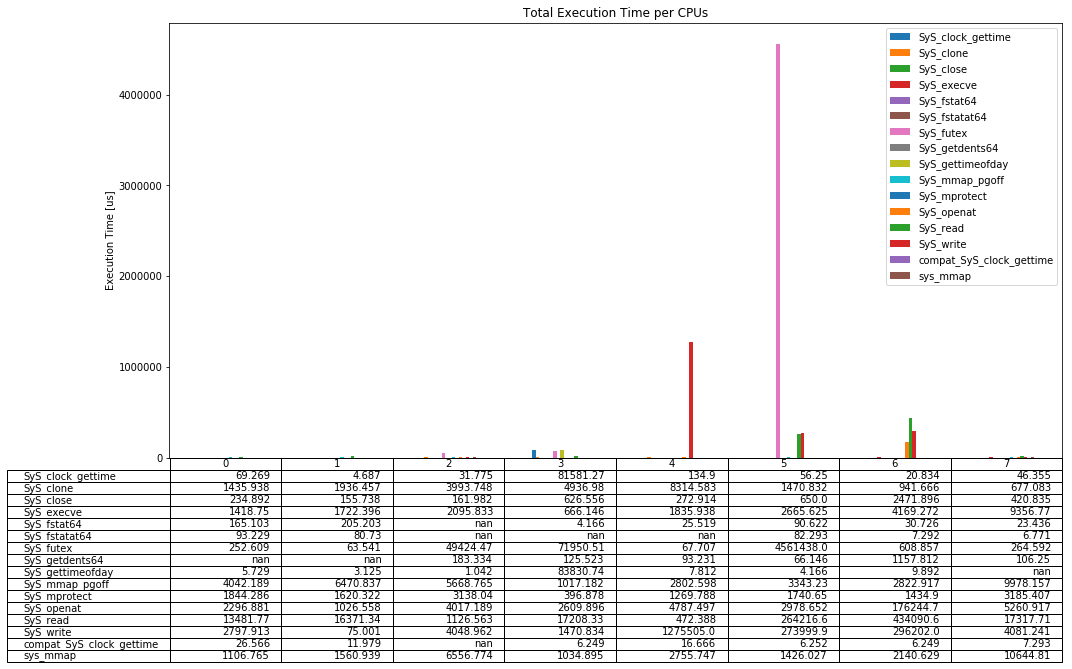

In [14]:
trace_kpti.analysis.functions.plotProfilingStats(
    functions = [
            "SyS_read",
            "SyS_write",
            "SyS_execve",
            "SyS_open",
            "SyS_openat",
            "SyS_fstat64",
            "SyS_fstatat64",
            "SyS_getdents",
            "SyS_getdents64",
            "SyS_close",
            "SyS_clock_gettime",
            "SyS_gettimeofday",
            "compat_SyS_clock_gettime",
            "sys_mmap",
            "SyS_mmap_pgoff",
            "SyS_mprotect",
            "SyS_clone",
            "SyS_futex",
    ],
    metrics = [
        'avg',
        'time',
    ]
)

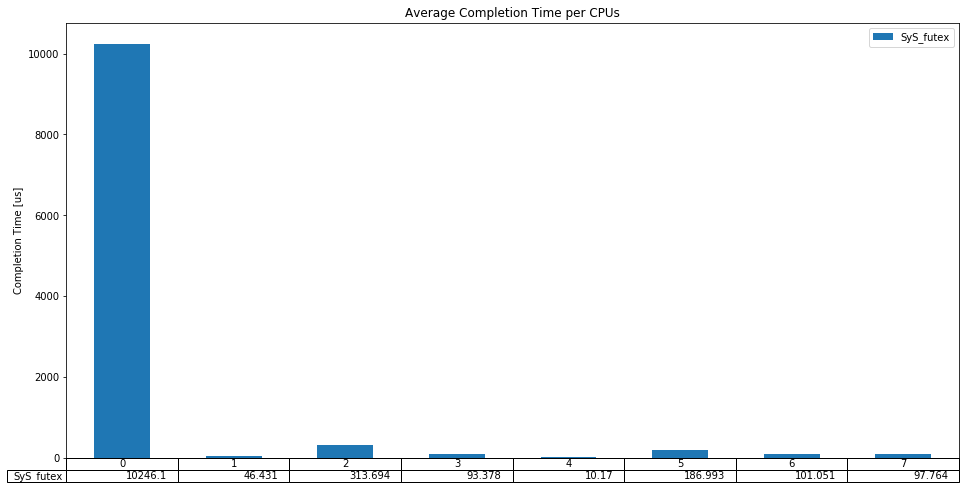

In [15]:
# Plot Average execution time for the single specified kernel function
trace.analysis.functions.plotProfilingStats(
    functions = [
            "SyS_futex",
     
                ],
    metrics = [
        'avg',
    ]
)

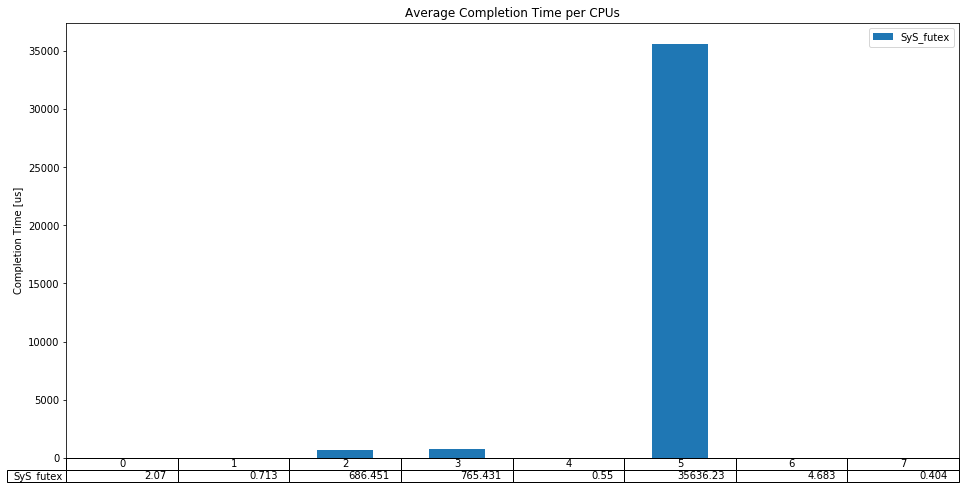

In [16]:
trace_kpti.analysis.functions.plotProfilingStats(
    functions = [
            "SyS_futex",
     
                ],
     metrics = [
        'avg',
    ]
)

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_syscall(fname, ax):
    base_avg=df['time_base'].sum()/df['hits_base'].sum()
    kpti_avg=df['time_kpti'].sum()/df['hits_kpti'].sum()
    pdr=pd.DataFrame({'base':[base_avg], 'kpti':[kpti_avg]})
    pdr.plot(kind='bar', title=fname, ax=ax)

In [142]:
my_conf['ftrace']['functions']

functions=['SyS_read',
 'SyS_write',
 'SyS_execve',
 'SyS_open',
 'SyS_clock_gettime',
 'SyS_gettimeofday',
 'SyS_mmap_pgoff',
 'SyS_futex']

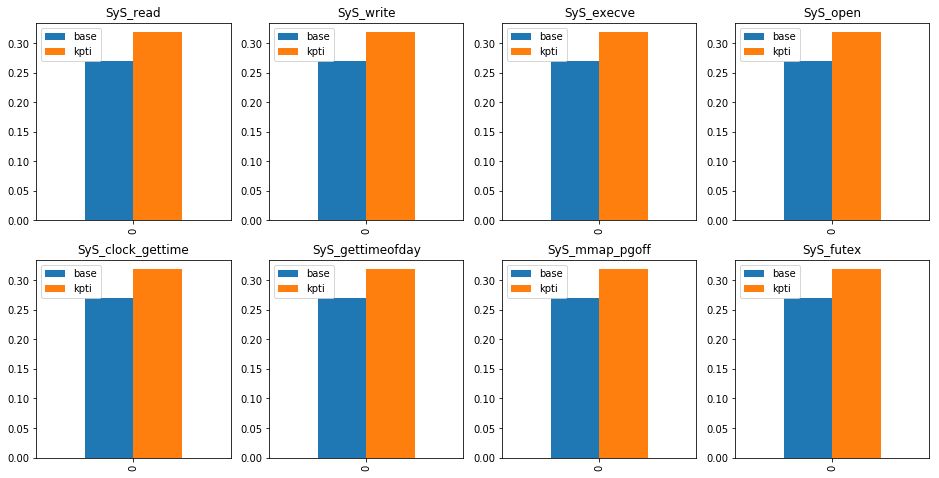

In [143]:
fcount = len(functions)

fig, pltaxes = plt.subplots(int(fcount/4),4, figsize=(16, 4*(fcount/4)))
id=0
for fname in functions:
    plot_syscall(fname, pltaxes[id/4][id%4])
    id=id+1